# Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from matplotlib import pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score

In [ ]:
# load dataset and show the first five sample
url = "https://raw.githubusercontent.com/NathaliaMinoque/datasets/refs/heads/main/property_data_clustering_clean.csv"
df = pd.read_csv(url)
df.head()

In [ ]:
# describe data
df.describe()

In [ ]:
df.shape

In [ ]:
# Check for info dataset
df.info()

In [ ]:
# show unique values from dataset
unique_values = {col: df[col].unique() for col in df.columns}
display(unique_values)

In [ ]:
# rename the Tingkat/Lantai column
df = df.rename(columns={"Tingkat/Lantai ": "Lantai"})
df.head()

In [ ]:
# drop Terjual/Belum karena valuenya sama semua "Belum"
df = df.drop('Terjual/Belum', axis=1)

In [ ]:
# drop Nama Daerah karena valuenya sangat banyak dan berbeda" valuenya
df = df.drop('Nama Daerah', axis=1)

# Exploratory Data Analysis

In [ ]:
# Scatter plot antara 'Luas Tanah (m2)' dan 'Luas Bangunan (m2)'
plt.figure(figsize=(8, 6))
plt.scatter(df['Luas Tanah (m2)'], df['Luas Bangunan (m2)'], color='blue')

plt.title('Scatter Plot Luas Tanah vs Luas Bangunan', fontsize=16)
plt.xlabel('Luas Tanah (m2)', fontsize=14)
plt.ylabel('Luas Bangunan (m2)', fontsize=14)

plt.show()

Insights : Plot ini menunjukkan adanya hubungan positif yang kuat antara luas tanah dan luas bangunan. Artinya, semakin besar ukuran tanah (Luas Tanah), semakin besar pula ukuran bangunan (Luas Bangunan). Ini menunjukkan bahwa properti dengan tanah yang lebih luas cenderung memiliki bangunan yang lebih besar, yang wajar secara logika. Sebagian besar data terlihat terkumpul di bagian bawah kiri (dengan luas tanah dan bangunan yang lebih kecil), yang menunjukkan banyak properti dengan ukuran tanah dan bangunan yang relatif kecil.

In [ ]:
# Boxplot antara harga penawaran berdasarkan kategori Area Category
plt.figure(figsize=(8, 6))
sns.boxplot(x='Area Category', y='Harga Penawaran (dari Owner)', data=df)
plt.title('Perbandingan Harga Penawaran Berdasarkan Area Category', fontsize=16)
plt.show()

Insights :
- Below Standard: Properti dalam kategori Below Standard memiliki harga penawaran yang terendah. Boxplot menunjukkan bahwa harga penawaran pada kategori ini sebagian besar terpusat di kisaran yang sangat rendah, dengan beberapa outliers yang mungkin menunjukkan properti dengan harga jauh lebih murah.

- Standard: Harga properti dalam kategori Standard sedikit lebih tinggi daripada Below Standard, tetapi masih dalam kisaran harga yang relatif rendah.

- Sangat Premium: Properti dalam kategori Sangat Premium memiliki harga penawaran yang paling tinggi. Boxplot menunjukkan bahwa harga pada kategori ini tersebar sangat lebar dengan beberapa outliers di sisi harga yang sangat tinggi, yang menunjukkan adanya properti sangat mahal di dalam kategori ini.

- Premium: Kategori Premium juga memiliki harga yang lebih tinggi dibandingkan dengan Standard dan Below Standard, namun Sangat Premium tetap berada di kisaran yang lebih tinggi. Properti di kategori Premium memiliki rentang harga yang lebih lebar, dengan harga yang bervariasi dari yang lebih terjangkau hingga sangat mahal.

# Data Transformation

In [ ]:
# duplicate df
df_encoded = df.copy()

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

# 1. Ordinal Encoding
# Columns: Area Category & Lebar
area_mapping = {'Below Standard': 0, 'Standard': 1, 'Premium': 2, 'Sangat Premium' : 3}
df_encoded['Area Category'] = df_encoded['Area Category'].map(area_mapping)
lebar_mapping = {'< 1 Mobil': 0, '1-2 Mobil': 1, '> 2 Mobil': 2}
df_encoded['Lebar Jalan Depan Rumah (ROW)'] = df_encoded['Lebar Jalan Depan Rumah (ROW)'].map(lebar_mapping)


# 2. Nominal Encoding
# Columns: Arah Hadap & Posisi
# Suppose you already fitted the encoder:
nominal_cols = ['Arah Hadap Rumah', 'Posisi Rumah']
encoder = OrdinalEncoder()
df_encoded[nominal_cols] = encoder.fit_transform(df_encoded[nominal_cols])

# Build a mapping dictionary
encode_dict = {}

for col, cats in zip(nominal_cols, encoder.categories_):
    encode_dict[col] = {category: int(code) for code, category in enumerate(cats)}

# Show the full dictionary
import pprint
pprint.pprint(encode_dict)

df_encoded.sample(n = 5)

In [ ]:
# Create a StandardScaler object
sc = StandardScaler()
df_scaled = df.copy

# Fit and transform the selected columns
df_scaled= sc.fit_transform(df[['Luas Tanah (m2)', 'Luas Bangunan (m2)', 'Jumlah Kamar', 'Jumlah Kamar Mandi', 'Lantai', 'Harga Penawaran (dari Owner)']])

df_scaled = pd.DataFrame(df_scaled, columns=['Luas Tanah (m2)', 'Luas Bangunan (m2)', 'Jumlah Kamar', 'Jumlah Kamar Mandi', 'Lantai', 'Harga Penawaran (dari Owner)'])
df_scaled.head()

In [ ]:
# get stastical information on the new dataset
df_scaled.describe()

In [ ]:
df_cat = df_encoded[['Area Category', 'Lebar Jalan Depan Rumah (ROW)', 'Arah Hadap Rumah', 'Posisi Rumah']]
df_cat.head()

In [ ]:
df_final = pd.concat([df_scaled, df_cat], axis=1)
df_final.head()

In [ ]:
# Define the range of clusters to test and linkage methods
range_n_clusters = range(2, 11)
linkage_methods = ['ward', 'complete', 'average', 'single']
metrics = ['euclidean', 'manhattan']

best_silhouette_score = -1
best_n_clusters = 0
best_linkage = ''
best_metric = ''

results_for_plotting = []

for linkage_method in linkage_methods:
    for metric in metrics:
        # Skip 'ward' linkage with 'manhattan' metric as it's not supported
        # ward gabisa manhattan, bisanya eucladian
        if linkage_method == 'ward' and metric == 'manhattan':
            print(f"Skipping Ward linkage with Manhattan metric (not supported).")
            continue

        current_scores = []
        for n_clusters in range_n_clusters:
            agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method, metric=metric)
            y_agglo = agglo.fit_predict(df_final)
            silhouette_avg = silhouette_score(df_final, y_agglo)
            current_scores.append(silhouette_avg)

            if silhouette_avg > best_silhouette_score:
                best_silhouette_score = silhouette_avg
                best_n_clusters = n_clusters
                best_linkage = linkage_method
                best_metric = metric
        results_for_plotting.append({
            'linkage': linkage_method,
            'metric': metric,
            'scores': current_scores
        })

# Plot the silhouette scores for each linkage method and metric combination
plt.figure(figsize=(12, 8))
for result in results_for_plotting:
    plt.plot(range_n_clusters, result['scores'], marker='o', label=f"{result['linkage']} - {result['metric']}")

plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Agglomerative Clustering with Different Linkage Methods and Metrics")
plt.legend()
plt.grid(True)
plt.show()

print(f"Best Silhouette Score: {best_silhouette_score}")
print(f"Optimal Number of Clusters: {best_n_clusters}")
print(f"Optimal Linkage Method: {best_linkage}")
print(f"Optimal Metric: {best_metric}")

Insights : Berdasarkan grafik Silhouette Score di atas, hasil analisis menunjukkan bahwa konfigurasi terbaik untuk algoritma Agglomerative Clustering dicapai dengan menggunakan metode linkage “complete” dan metrik jarak “euclidean” pada jumlah 2 cluster.

Nilai Silhouette Score tertinggi sebesar 0.7043 menandakan bahwa hasil pengelompokan sangat baik. Artinya, setiap data dalam cluster memiliki kemiripan yang tinggi dengan anggota dalam cluster yang sama, dan perbedaan yang jelas dengan cluster lain.

Secara keseluruhan, grafik ini menunjukkan bahwa dataset paling optimal dibagi menjadi dua kelompok besar, di mana kombinasi complete linkage dengan euclidean distance mampu memberikan struktur cluster yang paling terpisah dan konsisten dibandingkan metode lainnya seperti ward, average, atau single linkage.


# Hierarchical Clustering Modeling

In [100]:
# Hierarchical Clustering using Best Combination
agglo = AgglomerativeClustering(n_clusters=best_n_clusters, linkage=best_linkage, metric=best_metric)
y_hc_best = agglo.fit_predict(df_final)

# Evaluation
ss = silhouette_score(df_final, y_hc_best)
print("Complete Euclidean Score: ", ss)

Complete Euclidean Score:  0.7040722364263882


In [102]:
# Hierarchical Clustering using Ward Linkage
agglo = AgglomerativeClustering(n_clusters=best_n_clusters, linkage="ward")
y_hc = agglo.fit_predict(df_final)

# Evaluation
ss = silhouette_score(df_final, y_hc)
print("Complete Euclidean Score: ", ss)

Complete Euclidean Score:  0.38804599507165033


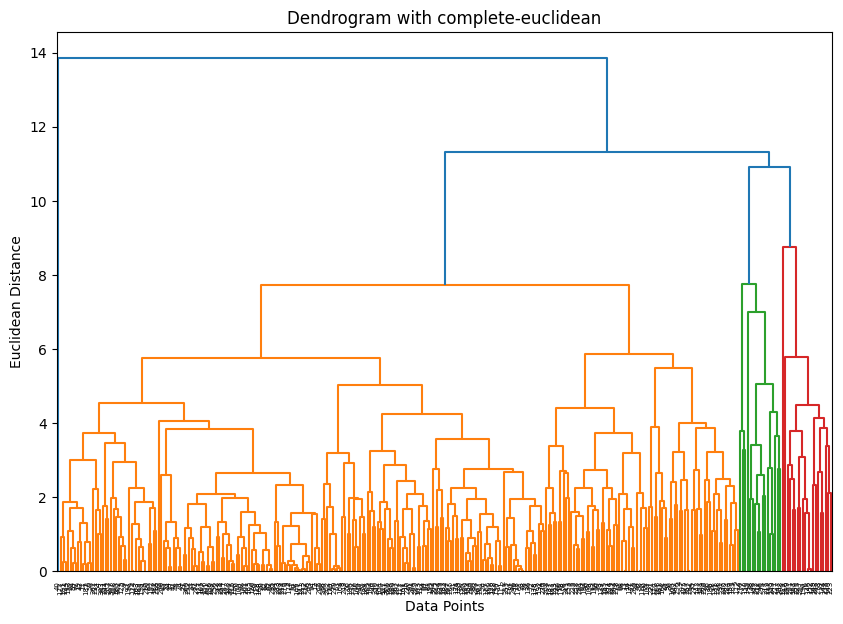

In [103]:
# Average Distance
linked = linkage(df_final, method=best_linkage, metric=best_metric)

# Plot dendrogram dengan color_threshold
plt.figure(figsize=(10, 7))
sch.dendrogram(linked)
plt.title("Dendrogram with " + best_linkage + "-" + best_metric)
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()

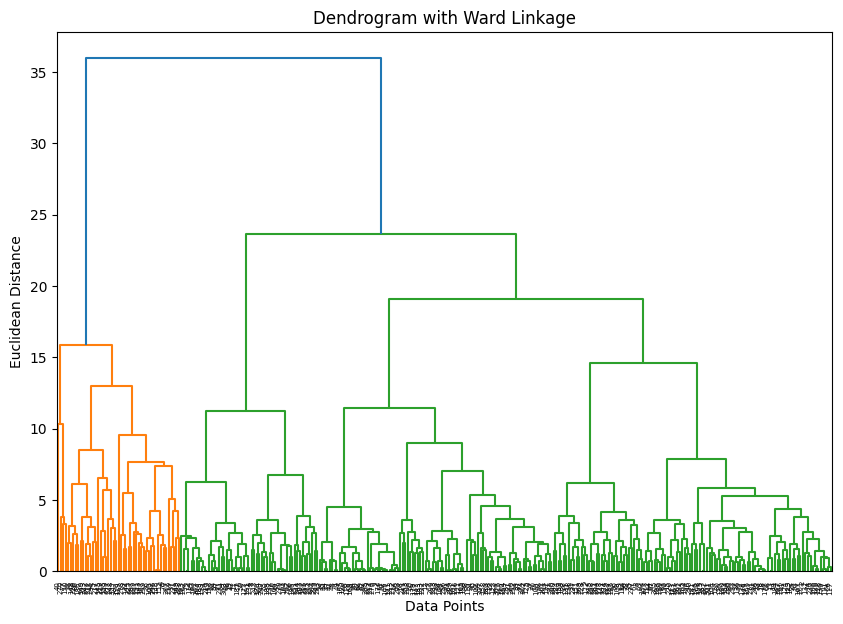

In [104]:
# Average Distance
linked = linkage(df_final, method="ward")

# Plot dendrogram dengan color_threshold
plt.figure(figsize=(10, 7))
sch.dendrogram(linked)
plt.title("Dendrogram with " + "Ward Linkage")
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()

In [105]:
# Add the cluster labels to the original data on best model
df['Agglo'] = y_hc_best

# Analyze the clusters with the original values
df.head()

,Area Category,Luas Tanah (m2),Luas Bangunan (m2),Jumlah Kamar,Jumlah Kamar Mandi,Lantai,Harga Penawaran (dari Owner),Arah Hadap Rumah,Posisi Rumah,Lebar Jalan Depan Rumah (ROW),Agglo
0,Standard,240,300,4,3,2,3500000000,Utara,Standard,1-2 Mobil,0
1,Below Standard,30,60,2,1,2,287799000,Utara,Standard,< 1 Mobil,0
2,Standard,170,170,5,4,2,2699999999,Selatan,Cul De Sac/Ujung Gang Buntu,1-2 Mobil,0
3,Sangat Premium,187,250,5,5,2,3100000000,Utara,Standard,1-2 Mobil,0
4,Premium,350,600,5,5,2,5000000000,Barat,Standard,1-2 Mobil,0


In [106]:
# Add the cluster labels to the original data on ward
df2 = df.copy()
df2['Agglo'] = y_hc

# Analyze the clusters with the original values
df2.head()

,Area Category,Luas Tanah (m2),Luas Bangunan (m2),Jumlah Kamar,Jumlah Kamar Mandi,Lantai,Harga Penawaran (dari Owner),Arah Hadap Rumah,Posisi Rumah,Lebar Jalan Depan Rumah (ROW),Agglo
0,Standard,240,300,4,3,2,3500000000,Utara,Standard,1-2 Mobil,0
1,Below Standard,30,60,2,1,2,287799000,Utara,Standard,< 1 Mobil,0
2,Standard,170,170,5,4,2,2699999999,Selatan,Cul De Sac/Ujung Gang Buntu,1-2 Mobil,0
3,Sangat Premium,187,250,5,5,2,3100000000,Utara,Standard,1-2 Mobil,0
4,Premium,350,600,5,5,2,5000000000,Barat,Standard,1-2 Mobil,1


# Comparison & Interpretation

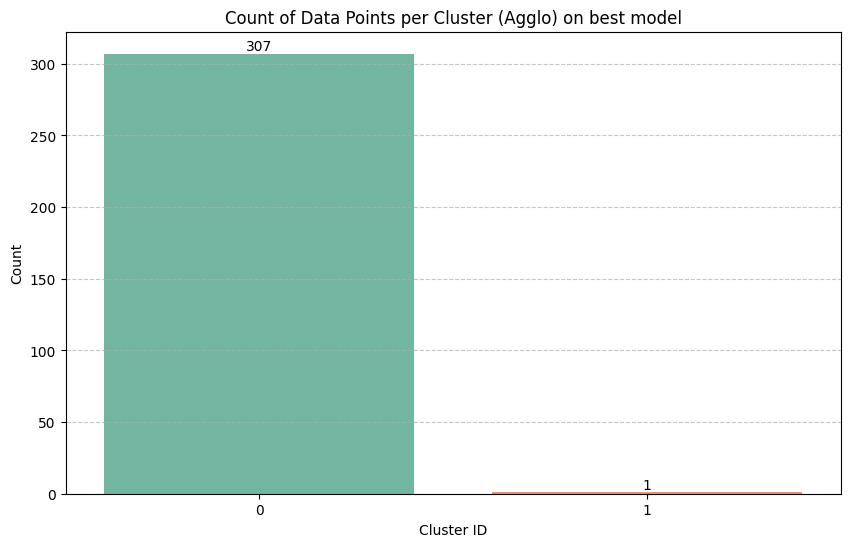

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the counts of each cluster in the 'Agglo' column of df
cluster_counts = df['Agglo'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=cluster_counts.index, y=cluster_counts.values, hue=cluster_counts.index, palette='Set2', legend=False)

# Add labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge')

plt.title('Count of Data Points per Cluster (Agglo) on best model')
plt.xlabel('Cluster ID')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Insights : Berdasarkan grafik distribusi jumlah data per cluster hasil Agglomerative Clustering, terlihat bahwa Cluster 0 berisi 307 data, sedangkan Cluster 1 hanya memiliki 1 data. Hal ini menunjukkan adanya ketidakseimbangan yang sangat signifikan antara kedua cluster tersebut.

Sebagian besar data terkonsentrasi dalam satu kelompok besar (Cluster 0), sementara satu data lainnya (Cluster 1) tampak sebagai outlier, yaitu data yang memiliki karakteristik sangat berbeda dari mayoritas, seperti nilai harga atau luas yang jauh lebih tinggi atau rendah.

Dengan demikian, hasil ini mengindikasikan bahwa meskipun algoritma berhasil menemukan dua cluster secara teknis, pembagian tersebut tidak merata dan kurang representatif untuk pola umum data. Kemungkinan besar, Cluster 1 merupakan data ekstrem, sedangkan Cluster 0 mencerminkan kelompok utama yang homogen.

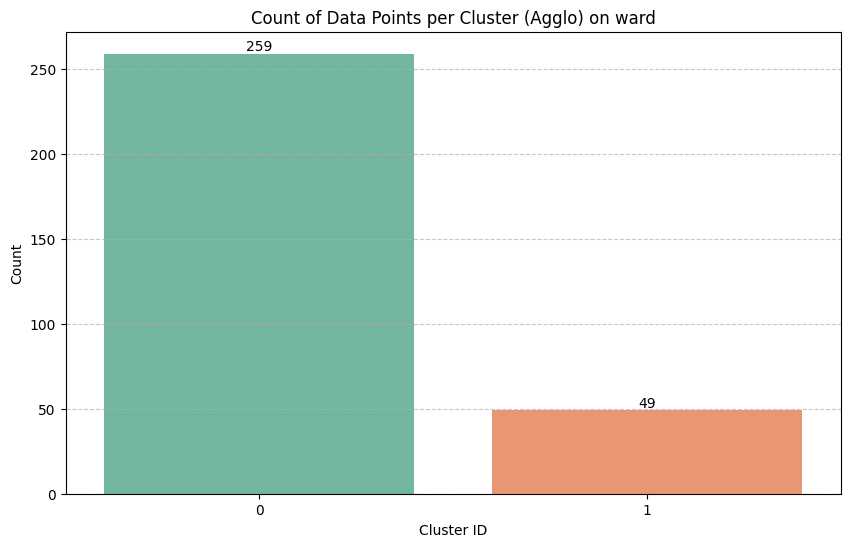

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the counts of each cluster in the 'Agglo' column of df
cluster_counts = df2['Agglo'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=cluster_counts.index, y=cluster_counts.values, hue=cluster_counts.index, palette='Set2', legend=False)

# Add labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge')

plt.title('Count of Data Points per Cluster (Agglo) on ward')
plt.xlabel('Cluster ID')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Insights : Berdasarkan grafik distribusi jumlah data per cluster menggunakan metode Agglomerative Clustering dengan linkage ward, terlihat bahwa Cluster 0 berisi 259 data, sedangkan Cluster 1 berisi 49 data.

Pembagian ini menunjukkan bahwa hasil clustering cukup seimbang dan bermakna, di mana tidak ada dominasi ekstrem seperti pada percobaan sebelumnya. Artinya, model berhasil mengelompokkan data menjadi dua segmen utama yang memiliki perbedaan karakteristik tertentu.

Secara umum, Cluster 0 dapat merepresentasikan kelompok properti dengan karakteristik umum atau menengah, sementara Cluster 1 mungkin berisi properti dengan ciri khas berbeda — misalnya memiliki harga lebih tinggi, ukuran lebih besar, atau berada di area lebih premium. Dengan demikian, hasil ini mengindikasikan bahwa metode ward mampu menghasilkan pembagian cluster yang lebih proporsional dan relevan untuk analisis segmentasi data properti.

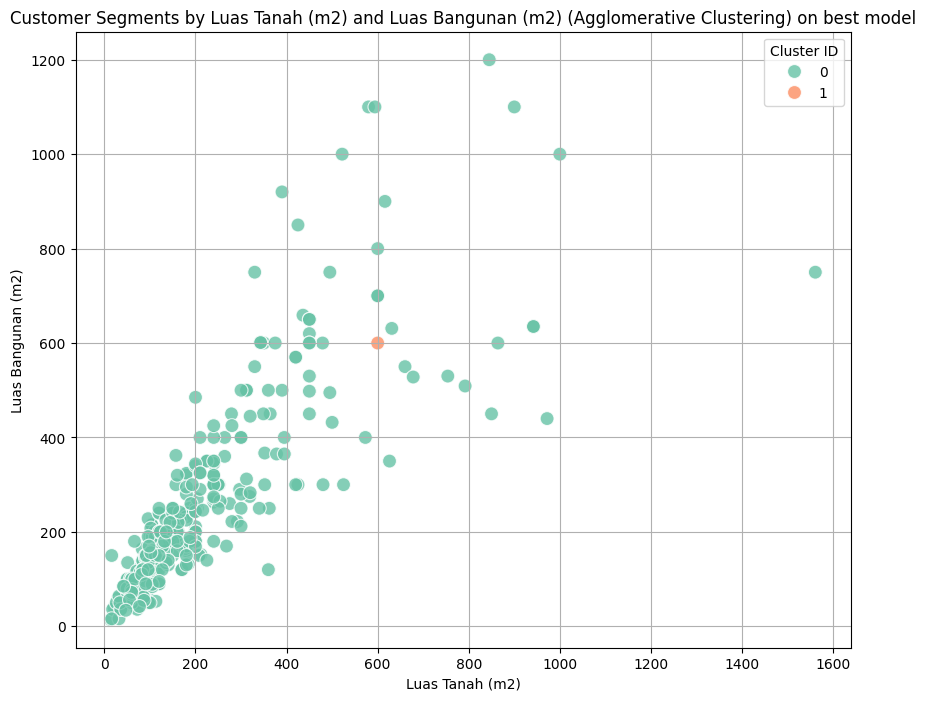

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='Luas Tanah (m2)', y='Luas Bangunan (m2)', hue='Agglo', palette='Set2', s=100, alpha=0.8)
plt.title('Customer Segments by Luas Tanah (m2) and Luas Bangunan (m2) (Agglomerative Clustering) on best model')
plt.xlabel('Luas Tanah (m2)')
plt.ylabel('Luas Bangunan (m2)')
plt.legend(title='Cluster ID')
plt.grid(True)
plt.show()

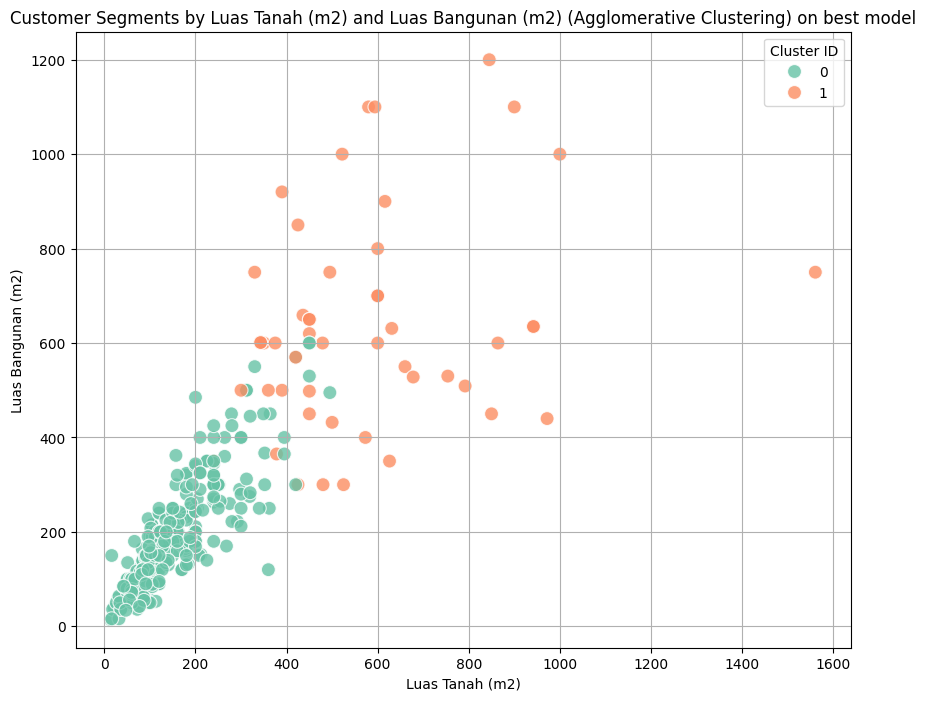

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.scatterplot(data=df2, x='Luas Tanah (m2)', y='Luas Bangunan (m2)', hue='Agglo', palette='Set2', s=100, alpha=0.8)
plt.title('Customer Segments by Luas Tanah (m2) and Luas Bangunan (m2) (Agglomerative Clustering) on best model')
plt.xlabel('Luas Tanah (m2)')
plt.ylabel('Luas Bangunan (m2)')
plt.legend(title='Cluster ID')
plt.grid(True)
plt.show()

Insights :
Berdasarkan hasil perbandingan kedua model Agglomerative Clustering, yaitu model best (complete linkage) dan ward linkage, terlihat bahwa metode ward linkage memberikan hasil segmentasi yang lebih bermakna dan seimbang dibandingkan metode complete linkage.

Pada model best (complete linkage), distribusi data sangat tidak seimbang, di mana Cluster 0 berisi 307 data, sementara Cluster 1 hanya memiliki 1 data. Hal ini menunjukkan bahwa pembagian cluster kurang efektif karena hampir seluruh data tergabung dalam satu kelompok besar, dan satu data lainnya merupakan outlier yang sangat berbeda dari mayoritas.

Sementara itu, pada model ward linkage, hasil pembagian lebih proporsional dengan Cluster 0 berisi 259 data dan Cluster 1 berisi 49 data. Selain itu, perbedaan nilai rata-rata (mean) pada variabel seperti Luas Tanah, Luas Bangunan, Jumlah Kamar, dan Harga Penawaran menunjukkan adanya karakteristik yang jelas antara kedua cluster, sehingga segmentasi ini lebih representatif dan mampu menggambarkan perbedaan nyata antar kelompok properti.

tetapi score complete euclidean lebih tinggi

In [74]:
# Group the data by cluster and calculate the mean spending and annual income for each cluster
cluster_summary = df_final.groupby(y_hc_best).agg({
    'Area Category': ['first', 'count'],
    'Lebar Jalan Depan Rumah (ROW)': ['first', 'count'],
    'Arah Hadap Rumah': ['first', 'count'],
    'Posisi Rumah': ['first', 'count'],
    'Luas Tanah (m2)': ['mean', 'std', 'min', 'max'],
    'Luas Bangunan (m2)': ['mean', 'std', 'min', 'max'],
    'Jumlah Kamar': ['mean', 'std', 'min', 'max'],
    'Lantai': ['mean', 'std', 'min', 'max'],
    'Harga Penawaran (dari Owner)': ['mean', 'std', 'min', 'max', 'size'],
})

# Rename the <lambda> column in the Gender MultiIndex level
cluster_summary = cluster_summary.rename(columns={'first': 'mode'}, level=1)

cluster_summary = cluster_summary.rename_axis('cluster')
print("Best Model")
cluster_summary

Best Model


Area Category       Lebar Jalan Depan Rumah (ROW)        \
                 mode count                          mode count   
cluster                                                           
0                   1   307                             1   307   
1                   1     1                             1     1   

        Arah Hadap Rumah       Posisi Rumah       Luas Tanah (m2)            \
                    mode count         mode count            mean       std   
cluster                                                                       
0                    3.0   307          2.0   307       -0.006031  0.997646   
1                    0.0     1          2.0     1        1.851418       NaN   

         ... Jumlah Kamar    Lantai                                \
         ...          max      mean       std       min       max   
cluster  ...                                                        
0        ...     5.315854  0.005401  0.998759 -1.658248  4.257663   
1        ...     1.659844 -1.658248       NaN -1.658248 -1.658248   

        Harga Penawaran (dari Owner)                                       
                                mean       std        min        max size  
cluster                                                                    
0                          -0.036894  0.765461  -0.585001   6.385411  307  
1                          11.326402       NaN  11.326402  11.326402    1  

[2 rows x 29 columns]

In [112]:
# Group the data by cluster and calculate the mean spending and annual income for each cluster
cluster_summary = df_final.groupby(y_hc).agg({
    'Area Category': ['first', 'count'],
    'Lebar Jalan Depan Rumah (ROW)': ['first', 'count'],
    'Arah Hadap Rumah': ['first', 'count'],
    'Posisi Rumah': ['first', 'count'],
    'Luas Tanah (m2)': ['mean', 'std', 'min', 'max'],
    'Luas Bangunan (m2)': ['mean', 'std', 'min', 'max'],
    'Jumlah Kamar': ['mean', 'std', 'min', 'max'],
    'Lantai': ['mean', 'std', 'min', 'max'],
    'Harga Penawaran (dari Owner)': ['mean', 'std', 'min', 'max', 'size'],
})

# Rename the <lambda> column in the Gender MultiIndex level
cluster_summary = cluster_summary.rename(columns={'first': 'mode'}, level=1)

cluster_summary = cluster_summary.rename_axis('cluster')
print("ward")
cluster_summary

ward


Area Category       Lebar Jalan Depan Rumah (ROW)        \
                 mode count                          mode count   
cluster                                                           
0                   1   259                             1   259   
1                   2    49                             1    49   

        Arah Hadap Rumah       Posisi Rumah       Luas Tanah (m2)            \
                    mode count         mode count            mean       std   
cluster                                                                       
0                    3.0   259          2.0   259       -0.333712  0.470642   
1                    0.0    49          2.0    49        1.763908  1.203740   

         ... Jumlah Kamar    Lantai                                \
         ...          max      mean       std       min       max   
cluster  ...                                                        
0        ...     2.878514 -0.028898  0.928364 -1.658248  2.285693   
1        ...     5.315854  0.152745  1.325086 -1.658248  4.257663   

        Harga Penawaran (dari Owner)                                     
                                mean      std       min        max size  
cluster                                                                  
0                          -0.274607  0.25809 -0.585001   1.143140  259  
1                           1.451494  1.87110 -0.272875  11.326402   49  

[2 rows x 29 columns]

Model Ward Linkage (Cluster 0 & Cluster 1)
Cluster 0 (n=259) — Properti Umum dengan Ukuran Standar dan Harga Menengah

Profil:
Properti dengan luas tanah dan bangunan relatif sedang, harga penawaran berada di kisaran menengah, serta sebagian besar berada pada area kategori Standard dan Below Standard.

Makna:
Cluster ini mewakili segmen pasar properti yang paling umum — mayoritas pembeli potensial dari kalangan menengah dengan preferensi harga terjangkau dan ukuran rumah yang proporsional.

Strategi:

Fokus pada promosi yang menekankan value for money dan kepraktisan.

Berikan opsi kredit, cicilan fleksibel, dan promo potongan DP.

Kampanye pemasaran melalui media digital (Instagram, marketplace properti).

Tawarkan program referral atau trade-in bagi pemilik rumah lama.

Fokus KPI:
Volume penjualan, tingkat konversi listing, dan rata-rata waktu penjualan (days on market).

Cluster 1 (n=49) — Properti Premium dengan Luas Besar dan Harga Tinggi

Profil:
Properti dengan luas tanah dan bangunan jauh di atas rata-rata, harga penawaran tinggi, dan banyak berasal dari area kategori Premium dan Sangat Premium.

Makna:
Cluster ini mencerminkan pasar segmen atas — pembeli dengan daya beli tinggi yang mencari kenyamanan, lokasi strategis, dan fasilitas eksklusif.

Strategi:

Gunakan pendekatan personalisasi dan layanan eksklusif (private viewing, konsultasi properti premium).

Fokus pada promosi di kanal berkelas (majalah properti, situs premium, pameran real estate).

Sediakan opsi investasi seperti rental management atau property yield simulation.

Bangun citra brand premium dengan konten visual berkualitas tinggi.

Fokus KPI:
Average Selling Price (ASP), tingkat konversi pembeli premium, dan retensi klien berdaya beli tinggi.


Model Best (Complete Euclidean) — Cluster Tidak Seimbang
Cluster 0 (n=307) — Mayoritas Properti Umum

Profil:
Hampir seluruh properti berada dalam cluster ini, dengan ukuran tanah dan bangunan yang bervariasi, namun cenderung pada kategori Standard dengan harga menengah.

Makna:
Cluster ini merepresentasikan seluruh pasar utama properti di dataset, dengan pembeli potensial dari kalangan menengah yang mencari rumah sesuai kebutuhan standar.

Strategi:

Fokus pada program pemasaran massal yang menjangkau audiens luas.

Gunakan strategi harga kompetitif untuk mempercepat penjualan.

Optimalisasi kehadiran di marketplace properti dan media sosial.

Sediakan fitur filter interaktif (lokasi, harga, tipe rumah) untuk memudahkan pencarian.

Fokus KPI:
Jumlah listing aktif, kecepatan penjualan, engagement rate iklan.

Cluster 1 (n=1) — Properti Anomali / Outlier

Profil:
Satu properti dengan karakteristik unik: ukuran tanah dan bangunan sangat besar atau harga penawaran jauh di atas rata-rata pasar.

Makna:
Properti ini termasuk outlier yang tidak mewakili pola umum — kemungkinan rumah mewah, bangunan komersial, atau properti dengan lokasi sangat strategis.

Strategi:

Perlakukan secara individual melalui pendekatan personal (one-on-one marketing).

Gunakan strategi niche marketing dengan menargetkan investor atau pembeli eksklusif.

Evaluasi apakah properti ini lebih cocok dikategorikan ulang ke segmen khusus (misalnya properti investasi).

Fokus KPI:
Tingkat minat (inquiry rate), lead premium, dan time-to-sell properti eksklusif.
